# Setup

In [ ]:
from transformer_lens.cautils.notebook import *

from transformer_lens.rs.callum.max_activating_exploration import print_best_outputs, find_best_improvements, clear_plots, decompose_attn_scores_full, decompose_attn_scores
from transformer_lens.rs.callum.keys_fixed import plot_contribution_to_attn_scores, create_fucking_massive_plot_1, create_fucking_massive_plot_2, project

clear_output()

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    # refactor_factored_attn_matrices=True,
)
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)

data = get_webtext(seed=6)

clear_output()

In [ ]:
LAYER_IDX, HEAD_IDX = (10, 7)
W_U = model.W_U.clone()
HEAD_HOOK_NAME = utils.get_act_name("result", LAYER_IDX)

NUM_PROMPTS = 100
BATCH_SIZE = 10

def hook_to_ablate_head(head_output: Float[Tensor, "batch seq_len head_idx d_head"], hook: HookPoint, head = (LAYER_IDX, HEAD_IDX)):
    assert head[0] == hook.layer()
    assert "result" in hook.name
    head_output[:, :, head[1], :] = 0
    return head_output

# Max activating examples for 10.7 (by ablation) 

Want to see where head 10.7 is most useful!

We can see cross-entropy loss increases by 0.01 on average when this head is ablated. That might seem like not a lot, but it's actually not far off distribution to other late-stage heads.

In [ ]:
str_token_list = []
loss_list = []
ablated_loss_list = []

for i in tqdm(range(NUM_PROMPTS)):
    # new_str = data[BATCH_SIZE * i: BATCH_SIZE * (i + 1)]
    new_str = data[i]
    new_str_tokens = model.to_str_tokens(new_str)
    tokens = model.to_tokens(new_str)
    # tokens = t.stack(tokens).to(device)
    loss = model(tokens, return_type="loss", loss_per_token=True)
    ablated_loss = model.run_with_hooks(tokens, return_type="loss", loss_per_token=True, fwd_hooks=[(HEAD_HOOK_NAME, hook_to_ablate_head)])
    loss_list.append(loss)
    ablated_loss_list.append(ablated_loss)
    str_token_list.append(new_str_tokens)


all_loss = t.cat(loss_list, dim=-1).squeeze()
all_ablated_loss = t.cat(ablated_loss_list, dim=-1).squeeze()

hist(
    all_ablated_loss - all_loss,
    title="Difference in loss after ablating (positive ⇒ loss increases)",
    labels={"x": "Difference in cross-entropy loss"},
    template="simple_white",
    add_mean_line=True,
    width=1000,
    nbins=200,
    static=True,
)

In [ ]:
total_num_tokens = sum(len(i) for i in str_token_list)
top_pct = int(total_num_tokens * 0.01)

best_k_indices, best_k_loss_decrease = find_best_improvements(str_token_list, loss_list, ablated_loss_list, k=top_pct)
worst_k_indices, worst_k_loss_decrease = find_best_improvements(str_token_list, loss_list, ablated_loss_list, k=top_pct, worst=True)

In [ ]:
caches_and_tokens = print_best_outputs(
    best_k_indices[:3],
    best_k_loss_decrease[:3],
    hook = (HEAD_HOOK_NAME, hook_to_ablate_head),
    model = model,
    data = data,
    n = 3,
    random = False,
    return_caches = True,
    names_filter = lambda name: name == utils.get_act_name("pattern", LAYER_IDX),
)

In [ ]:
p = Path("/home/ubuntu/Transformerlens/transformer_lens/rs/callum/plots")

clear_plots()

window = 100

for i, (cache, tokens) in enumerate(caches_and_tokens):
    
    pattern = cache["pattern", LAYER_IDX][:, HEAD_IDX]
    pattern_sliced = pattern[:, -window:, -window:]
    html = cv.attention.attention_heads(
        attention = pattern_sliced,
        tokens = tokens[-window:],
        attention_head_names = [f"{LAYER_IDX}.{HEAD_IDX}, example {i}"]
    )
    
    with open(str((p / f"temp_file_{i}.html").resolve()), "w") as f:
        f.write(str(html))

    print("".join(tokens[-window:]))
    print("\n" + "=" * 60 + "\n")

In [ ]:
clear_plots()

# Max activating examples for 10.7 (by removing direct effect) 

In [ ]:
str_token_list = []
loss_list = []
patched_loss_list = []

for i in tqdm(range(NUM_PROMPTS)):
    # new_str = data[BATCH_SIZE * i: BATCH_SIZE * (i + 1)]
    new_str = data[i]
    new_str_tokens = model.to_str_tokens(new_str)
    tokens = model.to_tokens(new_str)
    # tokens = t.stack(tokens).to(device)
    loss = model(tokens, return_type="loss", loss_per_token=True)
    patched_loss = path_patch(
        model=model,
        orig_input=tokens,
        new_cache="zero",
        sender_nodes=Node("z", layer=10, head=7),
        receiver_nodes=Node("resid_post", layer=11),
        direct_includes_mlps=True,
        patching_metric="loss_per_token"
    )
    loss_list.append(loss)
    patched_loss_list.append(patched_loss)
    str_token_list.append(new_str_tokens)


all_loss = t.cat(loss_list, dim=-1).squeeze()
all_patched_loss = t.cat(patched_loss_list, dim=-1).squeeze()

In [ ]:
hist(
    all_patched_loss - all_loss,
    title="Difference in loss after ablating (positive ⇒ loss increases)",
    labels={"x": "Difference in cross-entropy loss"},
    template="simple_white",
    add_mean_line=True,
    width=800,
    nbins=200,
    static=True,
)

In [ ]:
total_num_tokens = sum(len(i) for i in str_token_list)
top_pct = int(total_num_tokens * 0.01)
top_half_pct = int(total_num_tokens * 0.005)

best_k_indices, best_k_loss_decrease = find_best_improvements(str_token_list, loss_list, patched_loss_list, k=top_half_pct)
worst_k_indices, worst_k_loss_decrease = find_best_improvements(str_token_list, loss_list, patched_loss_list, k=top_half_pct, worst=True)
clear_output()

In [ ]:
caches_and_tokens = print_best_outputs(
    best_k_indices,
    best_k_loss_decrease,
    hook = (HEAD_HOOK_NAME, hook_to_ablate_head),
    model = model,
    data = data,
    n = 5,
    seed = 0,
    random = True,
    return_caches = False,
    # names_filter = lambda name: name == utils.get_act_name("pattern", LAYER_IDX),
)

# All's fair in love and war

First, verify that it does predict "love" with some prob. Yes, it does!

In [ ]:
str_input = "All's fair in love and"
answer = " war"
incorrect = " love"
model.reset_hooks()
utils.test_prompt(str_input, answer, model)

Now, I want to see what the direct effect of head 10.7 is on the logits.

In [ ]:
toks = model.to_tokens(str_input)

model.reset_hooks()
logits, cache = model.run_with_cache(toks, return_type="logits")
logits = logits[0, -1]

# resid_post = t.stack([
#     cache["resid_post", layer][0, -1]
#     for layer in range(model.cfg.n_layers)
# ])
# resid_post_normalized = resid_post / cache["scale"][0]

# logit_lens = einops.einsum(
#     resid_post_normalized, model.W_U,
#     "batch d_model, d_model d_vocab -> batch d_vocab",
# )

neg_head_output = cache["result", 10][0, -1, 7]
neg_head_logits = neg_head_output @ model.W_U
assert neg_head_logits.shape == (model.cfg.d_vocab,)
neg_head_logprobs = neg_head_logits.log_softmax(dim=-1)

top5 = neg_head_logprobs.topk(5, largest=False)

for index, value in zip(top5.indices, top5.values):
    token = model.to_single_str_token(index.item())
    print(f"|{token}| = {value:.2f}")

In [ ]:
all_attn = t.concat([
    cache["pattern", layer][0] for layer in range(12)
])
html = cv.attention.attention_heads(
    attention=all_attn,
    tokens=model.to_str_tokens(PROMPT),
    attention_head_names=[f"{layer}.{head_idx}" for layer in range(12) for head_idx in range(12)]
)
f = Path(r"/home/ubuntu/Transformerlens/transformer_lens/rs/callum/plots")
with open(f / "temp_file_3.html", "w") as f2:
    f2.write(str(html))

Amazing! Does it actually predict "love" if head 10.7 isn't firing?

In [ ]:
model.add_hook(HEAD_HOOK_NAME, hook_to_ablate_head)

utils.test_prompt(str_input, answer, model)

Yes, it does! (with second highest probability).

## Deeper dive into love and war

Now, let's break down this particular example, and see which heads are responsible for this dumb copying behaviour. I suspect it'll be one of the early ones.

Also, I originally thought that maybe nothing copies it (because war and love might be close embeddings). This is possible but unlikely, given love has pretty high logits without any interventions (and `" War"` doesn't, nor do any words like this).

### Direct logit attribution - which heads write in the "love" direction?

I'll look at `" love" - " war"` because this'll be easier. I'll crib code from the IOI notebook.

In [ ]:
# ANSWERS = [" os", " sys"]
# PROMPT = """import os\nimport"""

ANSWERS = [" love", " war"]
PROMPT = "All's fair in love and"

utils.test_prompt(PROMPT, ANSWERS[0], model)

In [ ]:
toks = model.to_tokens(PROMPT)

model.reset_hooks()
logits, cache = model.run_with_cache(toks, return_type="logits")
logits = logits[0, -1]

In [ ]:
answer_tokens = model.to_tokens(ANSWERS, prepend_bos=False).T

answer_residual_directions: Float[Tensor, "batch=1 2 d_model"] = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_residual_directions.shape)

love_residual_directions, war_residual_directions = answer_residual_directions.unbind(dim=1)
logit_diff_directions: Float[Tensor, "batch=1 d_model"] = love_residual_directions - war_residual_directions
print(f"Logit difference directions shape:", logit_diff_directions.shape)

def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
) -> Float[Tensor, "..."]:
    '''
    Gets the avg logit difference between the correct and incorrect answer for a given
    stack of components in the residual stream.
    '''
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1)
    return einops.einsum(scaled_residual_stack, logit_diff_directions, "... batch d_model, batch d_model -> ...") / batch_size

per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(per_head_residual, "(layer head) ... -> layer head ...", layer=model.cfg.n_layers)


per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
per_head_logit_repeat = residual_stack_to_logit_diff(per_head_residual, cache, logit_diff_directions=love_residual_directions)
per_head_logit_correct = residual_stack_to_logit_diff(per_head_residual, cache, logit_diff_directions=war_residual_directions)

imshow(
    t.stack([per_head_logit_repeat, per_head_logit_correct, per_head_logit_diffs]),
    facet_col=0,
    facet_labels=[repr(ANSWERS[0]), repr(ANSWERS[1]), repr(ANSWERS[0]) + " - " + repr(ANSWERS[1])],
    labels={"x":"Head", "y":"Layer"},
    title="Direct Logit Attribution For Each Head",
    width=1200,
    # static=True,
)

In [ ]:
line(
    [per_head_logit_repeat.sum(-1), per_head_logit_correct.sum(-1)],
    names=["' love'", "' war'"],
    labels={"index": "Layer", "value": "Logits", "variable": "Token"},
    title="Direct Logit Attribution For Heads In Each Layer",
    height=400,
    width=550,
)

It looks like there are quite a few heads which are writing `' love'` into the residual stream. `8.6` is most notable, but other important ones are `6.1`, `8.8`, `9.2`, `9.3`, `9.6`.

The important thing isn't which heads write to the residual stream though, it's whether `' love'` is present in the residual stream, and if so then by how much (and also what proportion of the `" love"` unembedding is used to construct the query?).

In [ ]:
def hook_fn_erase_residual_stream_direction(
    q_input: Float[Tensor, "batch seq n_heads d_model"],
    hook: HookPoint,
    seq_pos: Union[int, Int[Tensor, "batch"]],
    direction_to_erase: Float[Tensor, "d_model"],
    head_idx: int,
):
    '''
    Erases the component of `direction_to_erase` in the `q_input` vector.

    seq_pos: the positions we're patching at (for each elem in the batch)
    '''
    batch, seq_len = q_input.shape[:2]

    if isinstance(seq_pos, int):
        seq_pos = [seq_pos for _ in range(batch)]
    
    q_input_slice: Float[Tensor, "batch d_model"] = q_input[range(batch), seq_pos, head_idx]
    q_input_proj, q_input_perp = project(
        q_input_slice, 
        einops.repeat(direction_to_erase, "d_model -> batch d_model", batch=batch)
    )

    q_input[range(batch), seq_pos, head_idx] = q_input_perp
    return q_input


NNMH_LIST = [(10, 7), (11, 10)]

direction_to_erase = model.W_U.T[model.to_single_token(" love")]
seq_pos = model.to_str_tokens(PROMPT).index(" and")

model.reset_hooks()
for (layer, head_idx) in NNMH_LIST:
    model.add_hook(
        name = utils.get_act_name("q_input", layer), 
        hook = partial(hook_fn_erase_residual_stream_direction, direction_to_erase=direction_to_erase, seq_pos=seq_pos, head_idx=head_idx),
    )
# model.reset_hooks()

utils.test_prompt(PROMPT, ANSWERS[0], model)

# logits, cache = model.run_with_cache(
#     model.to_tokens(PROMPT),
#     names_filter = lambda name: name.endswith("pattern"),
# )

# cv.attention.attention_patterns(
#     attention = t.stack([
#         cache["pattern", layer][0, head_idx] for (layer, head_idx) in NNMH_LIST
#     ]),
#     tokens = model.to_str_tokens(PROMPT),
#     attention_head_names = [f"{layer}.{head_idx}" for layer, head_idx in NNMH_LIST],
# )

In [ ]:
toks = model.to_tokens(str_input)
dest_indices = t.tensor([-1])
src_indices = t.tensor([model.to_str_tokens(str_input).index(" love")]) # = -2

str_input_baseline = "All's fair in war and"
toks_baseline = model.to_tokens(str_input_baseline)
src_baseline_indices = t.tensor([model.to_str_tokens(str_input_baseline).index(" war")]) # = -2

# attn_scores_full = decompose_attn_scores_full(
#     toks = toks,
#     dest_indices = dest_indices,
#     src_indices = src_indices,
#     src_baseline_indices = None,
#     nnmh = (10, 7),
#     model = model,
#     use_effective_embedding = False,
#     use_layer0_heads = False
# )

# create_fucking_massive_plot_1(attn_scores_full)

contribution_to_attn_scores = decompose_attn_scores(
    toks = toks,
    dest_indices = dest_indices,
    src_indices = src_indices,
    src_baseline_indices = t.tensor([4]), # src_baseline_indices,
    toks_baseline = None, # toks_baseline,
    nnmh = (10, 7),
    model = model,
    decompose_by = "keys",
    intervene_on_query = "project_to_W_U_IO",
    intervene_on_key = "project_to_MLP0",
    use_effective_embedding = False,
    use_layer0_heads = False,
)

plot_contribution_to_attn_scores(
    t.stack([
        contribution_to_attn_scores[('IO_dir', 'MLP0_dir')],
        contribution_to_attn_scores[('IO_dir', 'MLP0_perp')],
        contribution_to_attn_scores[('IO_perp', 'MLP0_dir')],
        contribution_to_attn_scores[('IO_perp', 'MLP0_perp')],
    ]),
    decompose_by = "keys",
    facet_labels = [
        "q ∥ W<sub>U</sub>[IO], k ∥ MLP<sub>0</sub>",
        "q ∥ W<sub>U</sub>[IO], k ⊥ MLP<sub>0</sub>", 
        "q ⊥ W<sub>U</sub>[IO], k ∥ MLP<sub>0</sub>", 
        "q ⊥ W<sub>U</sub>[IO], k ⊥ MLP<sub>0</sub>"
    ],
    facet_col_wrap = 2,
    title = "Decompose on query-side, split by projections key & query-side"
)

In [ ]:
toks = model.to_tokens(str_input)
dest_indices = t.tensor([-1])
src_indices = t.tensor([model.to_str_tokens(str_input).index(" love")]) # = -2

str_input_baseline = "All's fair in war and"
toks_baseline = model.to_tokens(str_input_baseline)
src_baseline_indices = t.tensor([model.to_str_tokens(str_input_baseline).index(" war")]) # = -2

contribution_to_attn_scores = decompose_attn_scores(
    toks = toks,
    dest_indices = dest_indices,
    src_indices = src_indices,
    src_baseline_indices = t.tensor([4]), # src_baseline_indices,
    toks_baseline = None, # toks_baseline,
    nnmh = (10, 7),
    model = model,
    decompose_by = "keys",
    intervene_on_query = "project_to_W_U_IO",
    intervene_on_key = None,
    use_effective_embedding = False,
    use_layer0_heads = False,
)

plot_contribution_to_attn_scores(
    t.stack([
        contribution_to_attn_scores[('IO_dir', 'unchanged')],
        contribution_to_attn_scores[('IO_perp', 'unchanged')],
    ]),
    decompose_by = "keys",
    facet_labels = [
        "q ∥ W<sub>U</sub>[IO]",
        "q ⊥ W<sub>U</sub>[IO]", 
    ],
    facet_col_wrap = 2,
    title = "Decompose on query-side, split by projections key & query-side"
)

In [ ]:
contribution_to_attn_scores.keys()

## Dataset

In [ ]:
t.log(t.tensor(0.01 * 0.04))

In [ ]:
def test_prompt_for_copy_suppression(
    prompt: str,
    answer: str,
    repetition: str,
    nnmh_list = [(10, 7), (11, 10)],
    model = model,
    print_test_prompt: bool = False,
):
    model.reset_hooks()
    direction_to_erase = model.W_U.T[model.to_single_token(repetition)]

    prompt_str_tokens = model.to_str_tokens(prompt)
    # assert prompt_str_tokens[-1] == " and"
    seq_pos = len(prompt_str_tokens) - 1

    if print_test_prompt:
        display(HTML(f"<h2>Forward pass: <span style='color:red'>{prompt} ...</span></h2>"))
        utils.test_prompt(prompt, answer, model, top_k=5, prepend_space_to_answer=False)
    else:
        logprobs = model(prompt)[0, -1].log_softmax(dim=-1)[model.to_single_token(repetition)]
        

    for (layer, head_idx) in nnmh_list:
        model.add_hook(
            name = utils.get_act_name("q_input", layer), 
            hook = partial(hook_fn_erase_residual_stream_direction, direction_to_erase=direction_to_erase, seq_pos=seq_pos, head_idx=head_idx),
        )
    
    if print_test_prompt:
        display(HTML(f"<h2>Del NNMH projections: <span style='color:red'>{prompt} ...</span></h2>"))
        utils.test_prompt(prompt, answer, model, top_k=5, prepend_space_to_answer=False)
    else:
        new_logprobs = model(prompt)[0, -1].log_softmax(dim=-1)[model.to_single_token(repetition)]
        return new_logprobs - logprobs








# prompt = """import os
# import"""
# answer = " sys"
# repetition = " os"

prompt = """from sklearn.model_selection import train_test_split
from sklearn."""
answer = "linear"
repetition = "model"

# prompt = """import java.util.*;
# import java.io.*;
# import java.math.*;
# import java."""
# answer = "time"
# repetition = " math"

test_prompt_for_copy_suppression(
    prompt = """All's fair in love and""",
    answer = " war",
    repetition = " love",
    print_test_prompt = True,
)

In [ ]:
def get_head_proj_outputs(
    cache: ActivationCache,
    seq_pos: Union[int, Int[Tensor, "batch seq"]],
    head_list: List[Tuple[int, int]],
    direction_to_erase: Float[Tensor, "d_model"],
):
    all_results_proj = []

    batch = cache["result", 0].shape[0]
    if isinstance(seq_pos, int):
        seq_pos = [seq_pos for _ in range(batch)]
    
    for head in head_list:
        layer, head_idx = head
        result = cache["result", layer][range(batch), seq_pos, head_idx]
    
        result_proj, result_perp = project(
            result, 
            einops.repeat(direction_to_erase, "d_model -> batch d_model", batch=batch)
        )

        all_results_proj.append(result_proj)
    
    return sum(all_results_proj)


def test_prompt_for_copy_suppression_big_brained(
    prompt: str,
    answer: str,
    repetition: str,
    copy_heads_list: List[Tuple[int, int]],
    nnmh_list = [(10, 7), (11, 10)],
    model = model,
    print_test_prompt: bool = False,
):
    model.reset_hooks()
    direction_to_erase = model.W_U.T[model.to_single_token(repetition)]

    prompt_str_tokens = model.to_str_tokens(prompt)
    # assert prompt_str_tokens[-1] == " and"
    seq_pos = len(prompt_str_tokens) - 1

    logits, cache = model.run_with_cache(prompt, names_filter=lambda name: name.endswith("result"))
    if print_test_prompt:
        display(HTML(f"<h2>Forward pass: <span style='color:red'>{prompt} ...</span></h2>"))
        utils.test_prompt(prompt, answer, model, top_k=5, prepend_space_to_answer=False)
    else:
        logprobs = logits[0, -1].log_softmax(dim=-1)[model.to_single_token(repetition)]
    
    all_results_perp = get_head_proj_outputs(cache, seq_pos, head_list=copy_heads_list, direction_to_erase=direction_to_erase)

    for (layer, head_idx) in nnmh_list:
        model.add_hook(
            name = utils.get_act_name("q_input", layer), 
            hook = lambda q_input, hook: q_input - all_results_perp,
        )
    
    if print_test_prompt:
        display(HTML(f"<h2>Del NNMH projections: <span style='color:red'>{prompt} ...</span></h2>"))
        utils.test_prompt(prompt, answer, model, top_k=5, prepend_space_to_answer=False)
    else:
        new_logprobs = model(prompt)[0, -1].log_softmax(dim=-1)[model.to_single_token(repetition)]
        return new_logprobs - logprobs


INDUCTION_HEADS = [(5, 1), (6, 9), (7, 2), (7, 10), (9, 6), (9, 9)]
EARLY_INDUCTION_HEADS = [(5, 1), (6, 9), (7, 2), (7, 10)]
EARLY_HEADS = [(layer, head) for layer in range(10) for head in range(12)]

# prompt = """import os
# import"""
# answer = " sys"
# repetition = " os"

# prompt = """Behind the first door is a car.
# Behind the second door is a goat.
# Behind the third""" # and final door / and fourth doors
# answer = " and"
# repetition = " door"

prompt = """from sklearn.model_selection import train_test_split
from sklearn."""
answer = "linear"
repetition = "model"

# prompt = """library(ggplot2)
# library("""
# answer = "d"
# repetition = "gg"

# prompt = """import java.util.*;
# import java.io.*;
# import java.math.*;
# import java."""
# answer = "time"
# repetition = " math"

test_prompt_for_copy_suppression_big_brained(
    prompt = prompt,
    answer = answer,
    repetition = repetition,
    print_test_prompt = True,
    copy_heads_list = EARLY_INDUCTION_HEADS, # EARLY_HEADS, # INDUCTION_HEADS,
)

In [ ]:
cache["pattern", 10][0, 7]

In [ ]:
prompt = """from sklearn.model_selection import train_test_split
from sklearn."""
answer = "linear"
repetition = "model"

nnmh_list = [(10, 7), (11, 10)]

model.reset_hooks(including_permanent=True)
logits, cache = model.run_with_cache(prompt)

direction_to_erase = model.W_U.T[model.to_single_token(repetition)]
prompt_str_tokens = model.to_str_tokens(prompt)
batch = 1
seq_pos = len(prompt_str_tokens) - 1
all_results_perp = get_head_proj_outputs(cache, seq_pos, head_list=EARLY_HEADS, direction_to_erase=direction_to_erase)

def my_hook(q_input, hook, head_idx):
    q_input[range(batch), seq_pos, head_idx] -= all_results_perp
    return q_input

for (layer, head_idx) in nnmh_list:
    # model.add_hook(
    #     name = utils.get_act_name("q_input", layer), 
    #     hook = partial(my_hook, head_idx=head_idx),
    #     is_permanent = True,
    # )
    model.add_hook(
        name = utils.get_act_name("q_input", layer), 
        hook = partial(hook_fn_erase_residual_stream_direction, direction_to_erase=direction_to_erase, seq_pos=seq_pos, head_idx=head_idx),
    )

logits_patched, cache_patched = model.run_with_cache(prompt)
model.reset_hooks(including_permanent=True)

for L, H in nnmh_list:
    display(cv.attention.attention_patterns(
        tokens = model.to_str_tokens(prompt),
        attention = t.stack([cache["pattern", L][0, H], cache_patched["pattern", L][0, H], t.clamp(cache["pattern", L][0, H] - cache_patched["pattern", L][0, H], 0, 1)]),
        attention_head_names = [f"{L}.{H} clean", f"{L}.{H} patched", "Diff"],
    ))

    print(cache["pattern", L][0, H][-1, 5].item())
    print(cache_patched["pattern", L][0, H][-1, 5].item())

In [ ]:
s = r"""We remember him for his kindness and generosity
It's a balance of tradition and innovation
She loved the colors of pink and blue
The main ingredients are flour and sugar
They chose to adopt a lifestyle of simplicity and minimalism
Their marriage was a combination of trust and respect
The garden is full of birds and butterflies
This meal needs a touch of salt and pepper
The sunset was a blend of orange and purple
The store sells goods new and used
The climate here is both hot and humid
The area is known for its wine and cheese
The theme of the party was black and white
She's a blend of beauty and brains
This painting is a fusion of reality and fantasy
His life was a mixture of pleasure and pain
The landscape was filled with trees and flowers
She was a paradox of innocence and cunning
The play was a mix of tragedy and comedy
The book is a combination of facts and fiction
The sky was filled with stars and moonlight
We traveled by both land and sea
The pie was a combination of sweet and savory
This role requires both skill and dedication
The holiday was filled with rest and relaxation
Their home was full of love and warmth
The music was a blend of rhythm and melody
We saw a combination of elephants and lions
The path was full of twists and turns
Life is a puzzle of choices and consequences
His voice carried a tone of authority and confidence
The project demands a blend of creativity and precision
The dance performance was a mix of grace and energy
They navigated through challenges with resilience and determination
The painting depicted a harmony of light and shadow
The city is a melting pot of cultures and traditions
The movie captured a balance of laughter and tears
Their friendship was built on trust and loyalty
The dish had a combination of spicy and sweet flavors
The competition showcased a variety of skills and talents
The conversation flowed with ease and depth
The dress was a fusion of vintage and modern styles
The team displayed unity and teamwork on the field
The conversation revealed a mix of excitement and nervousness
The decision required a blend of logic and intuition
The exhibition featured a collection of paintings and sculptures
The journey offered a mix of challenges and rewards
The recipe called for a combination of herbs and spices
The story unfolded with twists and surprises
The meeting covered topics of importance and urgency
The performance was a fusion of music and dance
The ceremony celebrated love and commitment
The speech was a balance of humor and sincerity
The dish was a medley of flavors and textures
The puzzle contained a mixture of easy and difficult clues
The forest was filled with sounds of birds and animals
The dessert had a combination of sweetness and tanginess
The workshop explored the intersection of science and art
The concert showcased a blend of classical and contemporary
The presentation included a mix of visuals and data
The cityscape was a tapestry of lights and buildings
The relationship flourished with open communication and trust
The event was a fusion of fashion and culture
The hike offered a blend of breathtaking views and challenging
The negotiations required a combination of compromise and assertiveness
The artwork depicted a contrast of light and darkness
The conversation revealed a mix of emotions and perspectives
The performance blended storytelling and dance
The garden featured a variety of flowers and plants
The song was a harmony of voices and instruments
The recipe combined fresh ingredients and bold
The discussion explored different angles and possibilities
The room was filled with laughter and conversation
The landscape was a mix of mountains and valleys
The dance routine incorporated elements of strength and grace
The project combined research and creativity
The play evoked a range of emotions and reactions
The dish had a balance of sweetness and acidity
The exhibit showcased a mixture of paintings and sculptures
The relationship was a combination of love and friendship
The journey offered both challenges and rewards
The novel intertwined multiple storylines and perspectives
The presentation included a blend of visuals and statistics
The atmosphere was filled with energy and excitement
The dessert had a fusion of flavors and textures
The team demonstrated a mix of strategy and skill
The workshop explored the connection between art and technology
The movie was a medley of action and drama
The meeting covered a combination of topics and issues
The city was a blend of old and new
The forest was alive with the sounds of animals and birds
The dish had a combination of spicy and tangy
The class explored the intersection of science and philosophy
The performance combined dance and theater
The presentation included a mix of anecdotes and data
The relationship thrived on understanding and compromise
The event was a fusion of music and art
The hike provided a mix of breathtaking views and challenging
The artwork portrayed a juxtaposition of colors and shapes
The conversation revealed a blend of opinions and perspectives
The concert featured a fusion of jazz and rock music
The workshop delved into the synthesis of psychology and mindfulness
The dish consisted of a medley of vegetables and herbs
The speech delivered a combination of inspiration and motivation
The garden displayed a variety of fragrant flowers and greenery
The project required a balance of innovation and practicality
The play incorporated a mix of comedy and tragedy
The landscape offered a juxtaposition of serene lakes and mountains
The song blended different genres and musical styles
The class explored the fusion of literature and psychology
The meeting covered a variety of topics ranging from finance to sustainability
The city was a melting pot of diverse cultures and traditions
The forest was a mix of colorful trees and wildflowers
The dish had a harmony of spicy and savory
The workshop delved into the overlap of technology and education
The movie was a combination of suspense and romance
The presentation included a mix of real-life examples and theory
The relationship was a mixture of passion and stability
The event was a fusion of sports and entertainment
The conversation revealed a combination of curiosity and knowledge
The performance blended music and poetry
The discussion explored the intersection of politics and ethics
The exhibit showcased a mixture of sculptures and installations
The play evoked a range of emotions, from laughter to tears
The dance routine incorporated elements of traditional and modern
The song had a harmony of melodic vocals and rhythmic
The class explored the connection between biology and psychology
The meeting covered a combination of challenges and opportunities
The workshop explored the integration of art and sustainability"""

sentences = s.split("\n")

inputs = []

for prompt in sentences:
    prompt_split = prompt.split(" ")
    answer = " " + prompt_split[-1]
    repetition = " " + prompt_split[-3]
    prompt = " ".join(prompt_split[:-1])
    inputs.append((prompt, answer, repetition))

logprobs_diff = []

for prompt, answer, repetition in inputs:
    logprobs_diff.append(
        test_prompt_for_copy_suppression(
            prompt = prompt,
            answer = answer,
            repetition = repetition,
            print_test_prompt = False,
        ).item()
    )

In [ ]:
hist(logprobs_diff, width=700, template="simple_white", static=True, nbins=40, title="Naive Copy Suppression: logit difference from deleting unembedding of<br>earlier token from 10.7 & 11.10 query input")

In [ ]:
prompt = "One man's trash is another man's"
answer = " treasure"
repetition = " trash"

test_prompt_for_copy_suppression(
    prompt = prompt,
    answer = answer,
    repetition = repetition,
    print_test_prompt = True,
)

In [ ]:
# prompt = """import os
# import"""
# answer = " sys"
# repetition = " os"

prompt = """from sklearn.model_selection import train_test_split
from sklearn."""
answer = "linear"
repetition = "model"

prompt = """All's fair in love and"""
answer = " war"
repetition = "love"

# prompt = """import java.util.*;
# import java.io.*;
# import java.math.*;
# import java."""
# answer = "time"
# repetition = " math"

test_prompt_for_copy_suppression(
    prompt = prompt,
    answer = answer,
    repetition = repetition,
    print_test_prompt = True,
)

# prompt = """wOIEICALUIaoi apsmdu q wd qwdl po aslnk csa la wOIEICALUIaoi apsmdu q wd qwdl po aslnk csa"""
# answer = " la"
# repetition = " la"

In [ ]:
toks = model.to_tokens(prompt)

model.reset_hooks()
logits, cache = model.run_with_cache(toks, return_type="logits")
logits = logits[0, -1]

answer_tokens = model.to_tokens([repetition, answer], prepend_bos=False).T

answer_residual_directions: Float[Tensor, "batch=1 2 d_model"] = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_residual_directions.shape)

love_residual_directions, war_residual_directions = answer_residual_directions.unbind(dim=1)
logit_diff_directions: Float[Tensor, "batch=1 d_model"] = love_residual_directions - war_residual_directions
print(f"Logit difference directions shape:", logit_diff_directions.shape)

def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
) -> Float[Tensor, "..."]:
    '''
    Gets the avg logit difference between the correct and incorrect answer for a given
    stack of components in the residual stream.
    '''
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1)
    return einops.einsum(scaled_residual_stack, logit_diff_directions, "... batch d_model, batch d_model -> ...") / batch_size

per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(per_head_residual, "(layer head) ... -> layer head ...", layer=model.cfg.n_layers)


per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
per_head_logit_repeat = residual_stack_to_logit_diff(per_head_residual, cache, logit_diff_directions=love_residual_directions)
per_head_logit_correct = residual_stack_to_logit_diff(per_head_residual, cache, logit_diff_directions=war_residual_directions)

imshow(
    t.stack([per_head_logit_repeat, per_head_logit_correct, per_head_logit_diffs]),
    facet_col=0,
    facet_labels=[repr(repetition), repr(answer), repr(repetition) + " - " + repr(answer)],
    facet_label_size=16,
    labels={"x":"Head", "y":"Layer"},
    title="Direct Logit Attribution For Each Head",
    width=1200,
    # static=True,
)
imshow(
    per_head_logit_repeat,
    facet_label_size=16,
    labels={"x":"Head", "y":"Layer"},
    title='Direct Logit Attribution For Each Head, for <span style="font-family: \'Lucida Console\'; color; \'red\'">"model"</span>',
    width=700,
    # static=True,
    # text_auto=".2f"
)

In [ ]:
IH = [(7, 2), (7, 10), (9, 6)]

cv.attention.attention_patterns(
    tokens = model.to_str_tokens(prompt),
    attention = t.stack([cache["pattern", L][0, H] for L, H in IH]),
    attention_head_names = [f"{L}.{H}" for L, H in IH],
)

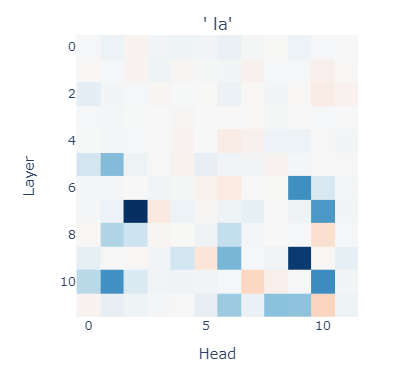